In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors

data = pd.read_csv("/content/Sleep_health_and_lifestyle_dataset.csv")

target_record_count = 9000

initial_count = len(data)
print(f"Initial record count: {initial_count}")

additional_records = target_record_count - initial_count

if additional_records > 0:
    categorical_columns = ['Gender', 'BMI Category']
    numerical_columns = ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level',
                         'Stress Level', 'Heart Rate', 'Daily Steps']

    # Handle Blood Pressure column separately due to the format (e.g., '120/80')
    bp_column = 'Blood Pressure'

    # Generating synthetic samples using nearest neighbors
    num_neighbors = min(5, initial_count - 1)
    nn = NearestNeighbors(n_neighbors=num_neighbors)
    nn.fit(data[numerical_columns])

    new_samples = []

    # Creating synthetic samples by interpolating between existing samples
    for _ in range(additional_records):
        base_idx = np.random.choice(initial_count)
        base_sample = data.iloc[base_idx]

        neighbors = nn.kneighbors([base_sample[numerical_columns]], return_distance=False)[0]
        random_neighbor_idx = np.random.choice(neighbors)
        neighbor_sample = data.iloc[random_neighbor_idx]

        synthetic_numerical = (base_sample[numerical_columns] + \
                              np.random.rand() * (neighbor_sample[numerical_columns] - base_sample[numerical_columns])).round().astype(int)

        synthetic_categorical = {
            col: np.random.choice([base_sample[col], neighbor_sample[col]])
            for col in categorical_columns
        }

        # interpolating between the two systolic and diastolic values
        base_bp = list(map(int, base_sample[bp_column].split('/')))
        neighbor_bp = list(map(int, neighbor_sample[bp_column].split('/')))
        synthetic_systolic = int(round(base_bp[0] + np.random.rand() * (neighbor_bp[0] - base_bp[0])))
        synthetic_diastolic = int(round(base_bp[1] + np.random.rand() * (neighbor_bp[1] - base_bp[1])))
        synthetic_bp = f"{synthetic_systolic}/{synthetic_diastolic}"

        # Combine all features into a single synthetic sample
        synthetic_sample = pd.Series({**synthetic_categorical, **synthetic_numerical, bp_column: synthetic_bp})
        new_samples.append(synthetic_sample)

    synthetic_data = pd.DataFrame(new_samples, columns=data.columns)

    augmented_data = pd.concat([data, synthetic_data], ignore_index=True)
else:
    augmented_data = data.copy()

print(f"Final augmented record count: {len(augmented_data)}")

augmented_data.to_csv("/content/augmented_sleep_health_dataset.csv", index=False)
print("Augmented dataset saved as 'augmented_sleep_health_dataset.csv'")
data = pd.read_csv("/content/augmented_sleep_health_dataset.csv")
print(data)

In [ ]:

# Load the dataset and drop the 'education' column
_data = pd.read_csv("/content/framingham[1].csv")
modified_data = _data.drop(columns=['education'])

# Save the modified dataset to a new CSV file
modified_data.to_csv("/content/framingham_modified.csv", index=False)

# Set pandas display options to show all columns
pd.set_option('display.max_columns', None)

# Display the first 100 records of the modified dataset
print("First 100 records of the modified dataset:")
print(modified_data.head(100))

# Display the total number of records in the modified dataset
print(f"\nTotal records in modified dataset: {len(modified_data)}")

print("\nModified dataset saved as 'framingham_modified.csv'.")


First 100 records of the modified dataset:
    male  age  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0      1   39              0         0.0     0.0                0   
1      0   46              0         0.0     0.0                0   
2      1   48              1        20.0     0.0                0   
3      0   61              1        30.0     0.0                0   
4      0   46              1        23.0     0.0                0   
..   ...  ...            ...         ...     ...              ...   
95     0   65              0         0.0     0.0                0   
96     0   63              1        20.0     0.0                0   
97     0   40              0         0.0     0.0                0   
98     0   56              0         0.0     0.0                0   
99     0   56              1        15.0     0.0                0   

    prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0              0         0    195.0  106.0   70.

In [ ]:
import pandas as pd


sleep_data = pd.read_csv("/content/augmented_sleep_health_dataset.csv")  # Sleep health dataset
heart_data = pd.read_csv("/content/framingham_modified.csv")  # Framingham heart disease dataset

sleep_data = sleep_data.rename(columns={
    'Gender': 'gender',
    'Age': 'age',
    'Blood Pressure': 'bp',
    'Heart Rate': 'heartRate'
})

sleep_data[['sysBP', 'diaBP']] = sleep_data['bp'].str.split('/', expand=True).astype(float)
sleep_data = sleep_data.drop(columns=['bp'])

heart_data = heart_data.rename(columns={
    'male': 'gender',
    'sysBP': 'sysBP',
    'diaBP': 'diaBP',
    'heartRate': 'heartRate'
})
heart_data['gender'] = heart_data['gender'].map({1: 'Male', 0: 'Female'})

# Merge on gender and age only
merged_data = pd.merge(sleep_data, heart_data, how='inner', on=['gender', 'age'])


merged_data = merged_data[
    (merged_data['sysBP_x'] - 5 <= merged_data['sysBP_y']) & (merged_data['sysBP_x'] + 5 >= merged_data['sysBP_y']) &
    (merged_data['diaBP_x'] - 5 <= merged_data['diaBP_y']) & (merged_data['diaBP_x'] + 5 >= merged_data['diaBP_y']) &
    (merged_data['heartRate_x'] - 5 <= merged_data['heartRate_y']) & (merged_data['heartRate_x'] + 5 >= merged_data['heartRate_y'])
]


merged_data = merged_data.drop(columns=['sysBP_y', 'diaBP_y', 'heartRate_y']).rename(columns={
    'sysBP_x': 'sysBP',
    'diaBP_x': 'diaBP',
    'heartRate_x': 'heartRate'
})


print("\nMerged Dataset Sample:")
print(merged_data.head())
print(f"\nTotal records in merged dataset: {len(merged_data)}")

merged_data.to_csv("/content/merged_dataset.csv", index=False)



Merged Dataset Sample:
   gender  age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
65   Male   35             6.7                 7                       40   
66   Male   35             6.7                 7                       40   
82   Male   35             6.7                 7                       40   
83   Male   35             6.7                 7                       40   
95   Male   35             7.5                 8                       60   

    Stress Level   BMI Category  heartRate  Daily Steps  sysBP  diaBP  \
65             5     Overweight         70         5600  128.0   84.0   
66             5     Overweight         70         5600  128.0   84.0   
82             5     Overweight         70         5600  128.0   84.0   
83             5     Overweight         70         5600  128.0   84.0   
95             5  Normal Weight         70         8000  120.0   80.0   

    currentSmoker  cigsPerDay  BPMeds  prevalentStroke  prevalentHyp  \
65

In [ ]:
import pandas as pd


sleep_data = pd.read_csv("/content/augmented_sleep_health_dataset.csv")  # Sleep health dataset
heart_data = pd.read_csv("/content/framingham_modified.csv")  # Framingham heart disease dataset


sleep_data = sleep_data.rename(columns={
    'Gender': 'gender',
    'Age': 'age',
    'Blood Pressure': 'bp',
    'Heart Rate': 'heartRate'
})

sleep_data[['sysBP', 'diaBP']] = sleep_data['bp'].str.split('/', expand=True).astype(float)
sleep_data = sleep_data.drop(columns=['bp'])

# Rename 'male' column in heart_data to 'gender' and map to 'Male'/'Female'
heart_data = heart_data.rename(columns={
    'male': 'gender',
    'sysBP': 'sysBP',
    'diaBP': 'diaBP',
    'heartRate': 'heartRate'
})
heart_data['gender'] = heart_data['gender'].map({1: 'Male', 0: 'Female'})


merged_data = pd.merge(sleep_data, heart_data, how='inner', on=['gender', 'age'])


merged_data = merged_data[
    (merged_data['sysBP_x'] - 5 <= merged_data['sysBP_y']) & (merged_data['sysBP_x'] + 5 >= merged_data['sysBP_y']) &
    (merged_data['diaBP_x'] - 5 <= merged_data['diaBP_y']) & (merged_data['diaBP_x'] + 5 >= merged_data['diaBP_y']) &
    (merged_data['heartRate_x'] - 5 <= merged_data['heartRate_y']) & (merged_data['heartRate_x'] + 5 >= merged_data['heartRate_y'])
]


merged_data = merged_data.drop(columns=['sysBP_y', 'diaBP_y', 'heartRate_y']).rename(columns={
    'sysBP_x': 'sysBP',
    'diaBP_x': 'diaBP',
    'heartRate_x': 'heartRate'
})
# trimmed_data = merged_data.head(2000)
# merged_data = trimmed_data
# Display the merged dataset
print("\nMerged Dataset Sample:")
print(merged_data.head())
print(f"\nTotal records in merged dataset: {len(merged_data)}")

merged_data.to_csv("/content/merged_dataset.csv", index=False)



Merged Dataset Sample:
   gender  age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
65   Male   35             6.7                 7                       40   
66   Male   35             6.7                 7                       40   
82   Male   35             6.7                 7                       40   
83   Male   35             6.7                 7                       40   
95   Male   35             7.5                 8                       60   

    Stress Level   BMI Category  heartRate  Daily Steps  sysBP  diaBP  \
65             5     Overweight         70         5600  128.0   84.0   
66             5     Overweight         70         5600  128.0   84.0   
82             5     Overweight         70         5600  128.0   84.0   
83             5     Overweight         70         5600  128.0   84.0   
95             5  Normal Weight         70         8000  120.0   80.0   

    currentSmoker  cigsPerDay  BPMeds  prevalentStroke  prevalentHyp  \
65

Initial Data:
  gender  age  Sleep Duration  Quality of Sleep  Physical Activity Level  \
0   Male   35             6.7                 7                       40   
1   Male   35             6.7                 7                       40   
2   Male   35             6.7                 7                       40   
3   Male   35             6.7                 7                       40   
4   Male   35             7.5                 8                       60   

   Stress Level   BMI Category  heartRate  Daily Steps  sysBP  diaBP  \
0             5     Overweight         70         5600  128.0   84.0   
1             5     Overweight         70         5600  128.0   84.0   
2             5     Overweight         70         5600  128.0   84.0   
3             5     Overweight         70         5600  128.0   84.0   
4             5  Normal Weight         70         8000  120.0   80.0   

   currentSmoker  cigsPerDay  BPMeds  prevalentStroke  prevalentHyp  diabetes  \
0              

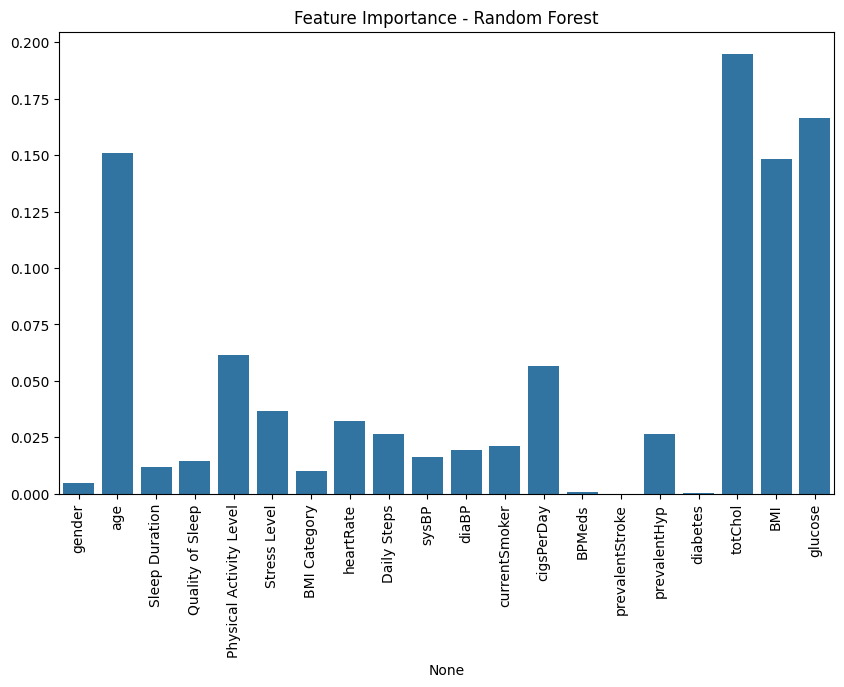

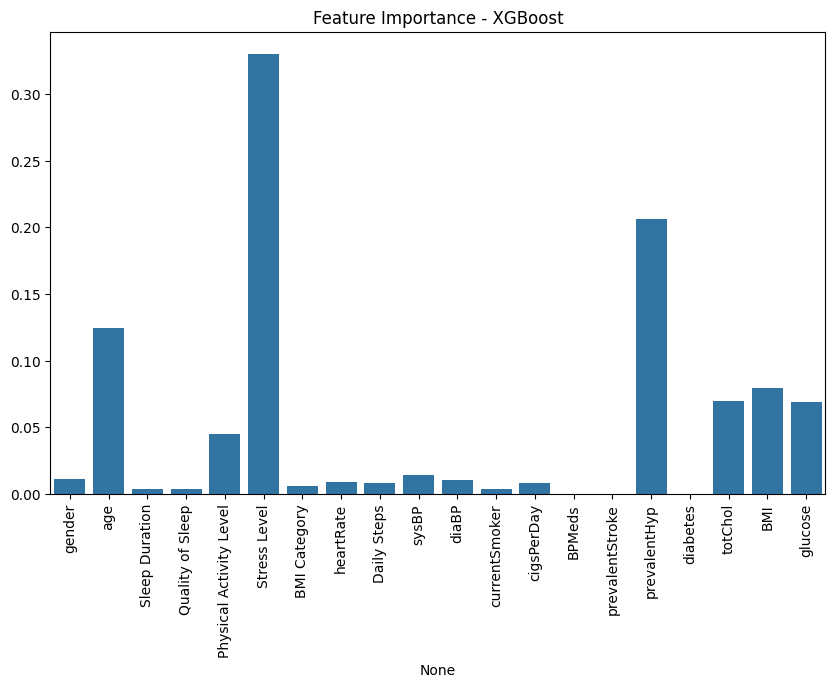

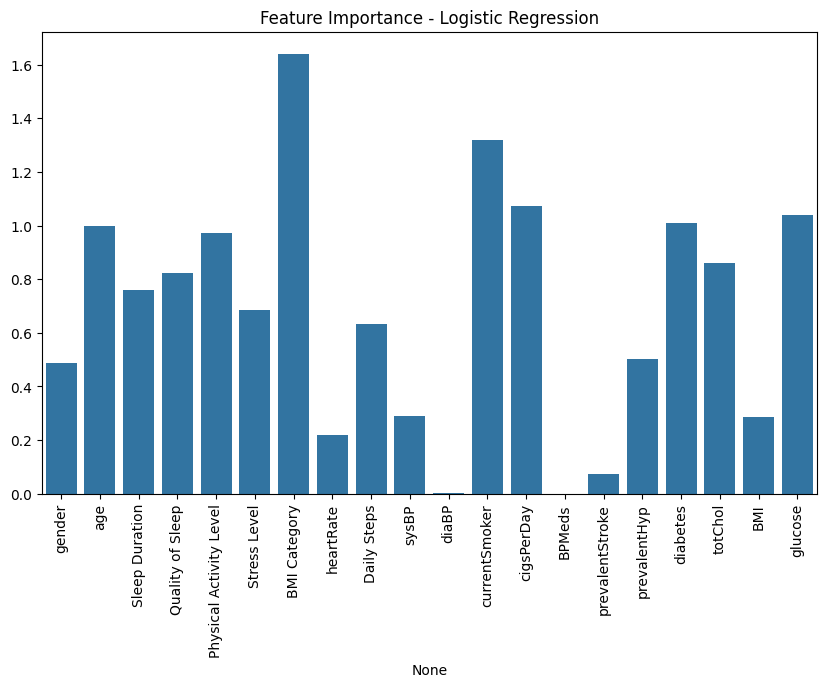

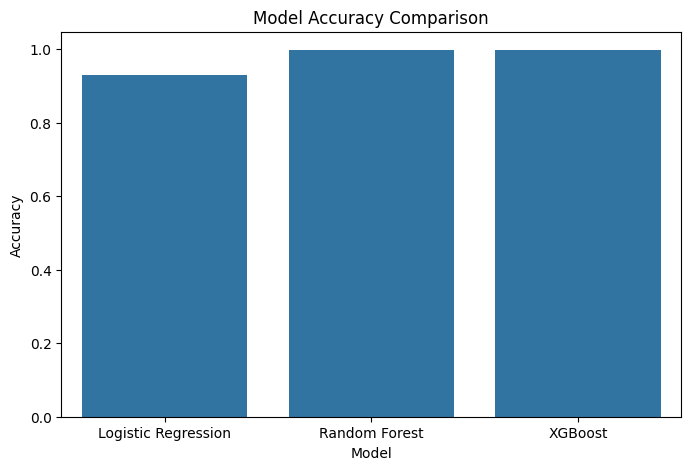

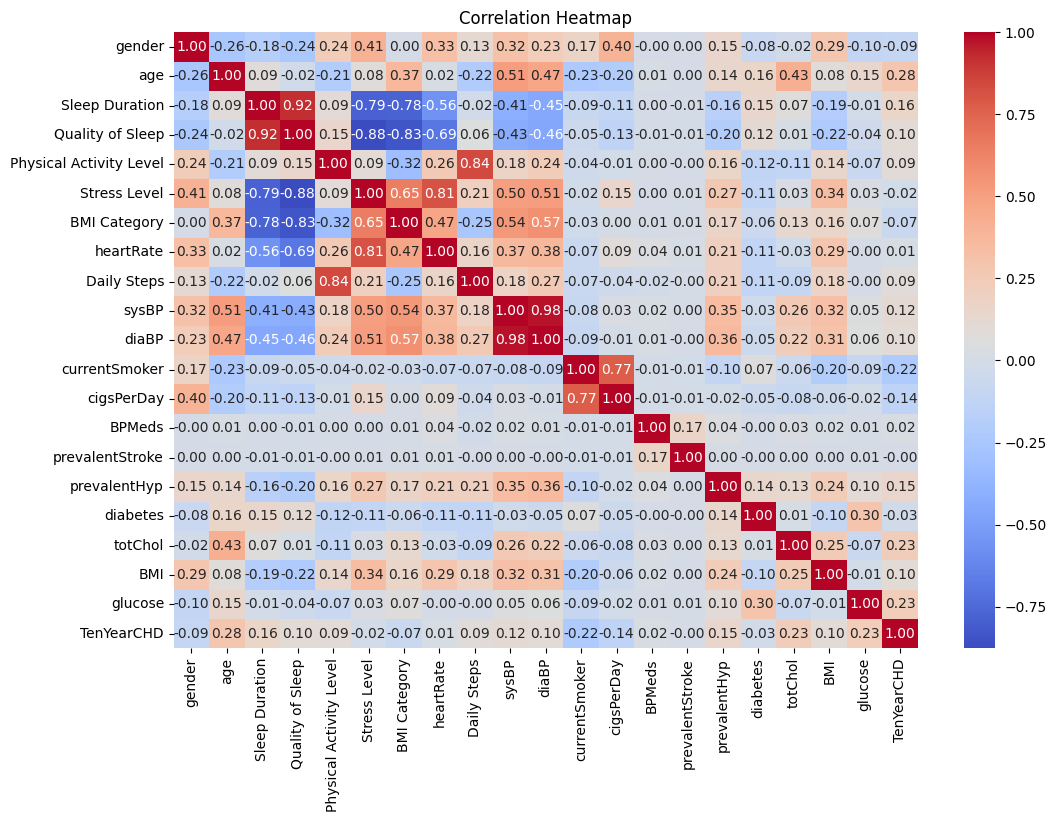

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder


merged_data_cleaned = pd.read_csv('/content/merged_dataset.csv')
print("Initial Data:")
print(merged_data_cleaned.head())


categorical_cols = ['gender', 'BMI Category']


for col in categorical_cols:

    merged_data_cleaned[col] = merged_data_cleaned[col].fillna('Unknown')


label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    merged_data_cleaned[col] = le.fit_transform(merged_data_cleaned[col])
    label_encoders[col] = le


numerical_cols = ['age', 'Stress Level', 'heartRate', 'Daily Steps', 'sysBP', 'diaBP',
                  'cigsPerDay', 'totChol', 'BMI', 'glucose', 'BPMeds']

imputer = SimpleImputer(strategy='mean')
merged_data_cleaned[numerical_cols] = imputer.fit_transform(merged_data_cleaned[numerical_cols])



print("\nMissing values after handling:")
print(merged_data_cleaned.isnull().sum())


X = merged_data_cleaned.drop('TenYearCHD', axis=1)
y = merged_data_cleaned['TenYearCHD']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Logistic Regression with increased iterations
logreg_model = LogisticRegression(max_iter=9000, solver='saga')
logreg_model.fit(X_train, y_train)
logreg_predictions = logreg_model.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)
logreg_classification_report = classification_report(y_test, logreg_predictions)

# Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_classification_report = classification_report(y_test, rf_predictions)

# XGBoost Classifier
xgb_model = XGBClassifier(n_estimators=100, random_state=42)
xgb_model.fit(X_train, y_train)
xgb_predictions = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
xgb_classification_report = classification_report(y_test, xgb_predictions)

# Printing Results
print("\nLogistic Regression Accuracy:", logreg_accuracy)
print("\nLogistic Regression Classification Report:\n", logreg_classification_report)

print("\nRandom Forest Accuracy:", rf_accuracy)
print("\nRandom Forest Classification Report:\n", rf_classification_report)

print("\nXGBoost Accuracy:", xgb_accuracy)
print("\nXGBoost Classification Report:\n", xgb_classification_report)

# Feature Importance using Random Forest
rf_feature_importances = rf_model.feature_importances_
features = X.columns

# feature importance for Random Forest
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=rf_feature_importances)
plt.title("Feature Importance - Random Forest")
plt.xticks(rotation=90)
plt.show()

# Feature Importance using XGBoost
xgb_feature_importances = xgb_model.feature_importances_

#feature importance for XGBoost
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=xgb_feature_importances)
plt.title("Feature Importance - XGBoost")
plt.xticks(rotation=90)
plt.show()

# Feature Importance using Logistic Regression (
logreg_feature_importances = np.abs(logreg_model.coef_[0])  # Using absolute values of coefficients

#  feature importance for Logistic Regression
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=logreg_feature_importances)
plt.title("Feature Importance - Logistic Regression")
plt.xticks(rotation=90)
plt.show()

# accuracy of all models
accuracy_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost'],
    'Accuracy': [logreg_accuracy, rf_accuracy, xgb_accuracy]
})

#  accuracy comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=accuracy_comparison)
plt.title("Model Accuracy Comparison")
plt.show()

# correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(merged_data_cleaned.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap")
plt.show()



Ensemble Model (Random Forest + XGBoost) Accuracy: 0.9979992724627137

Ensemble Model Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      4986
           1       1.00      0.98      0.99       512

    accuracy                           1.00      5498
   macro avg       1.00      0.99      0.99      5498
weighted avg       1.00      1.00      1.00      5498



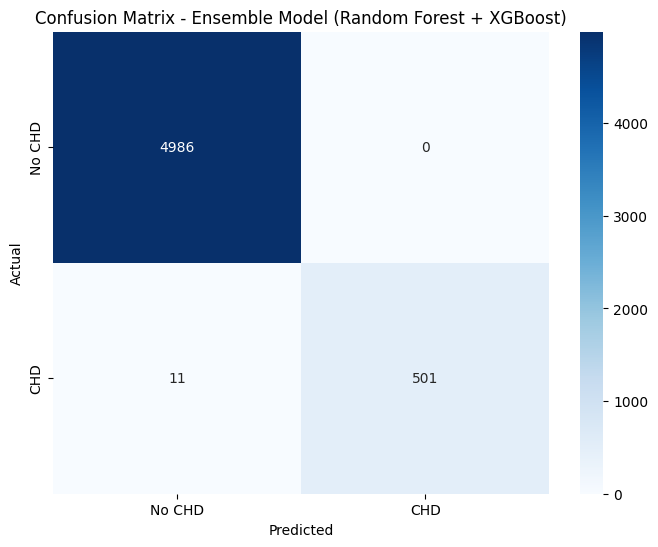

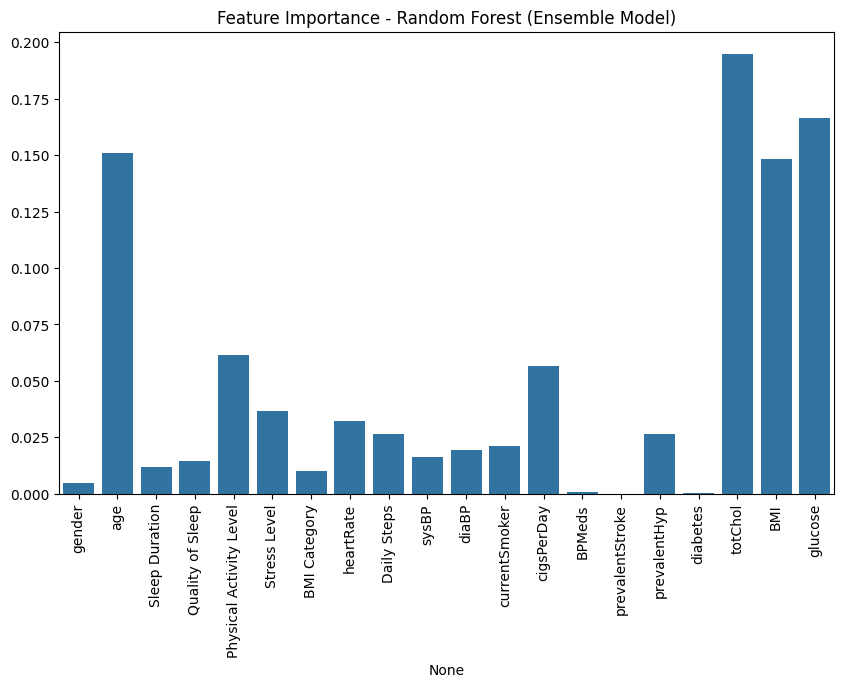

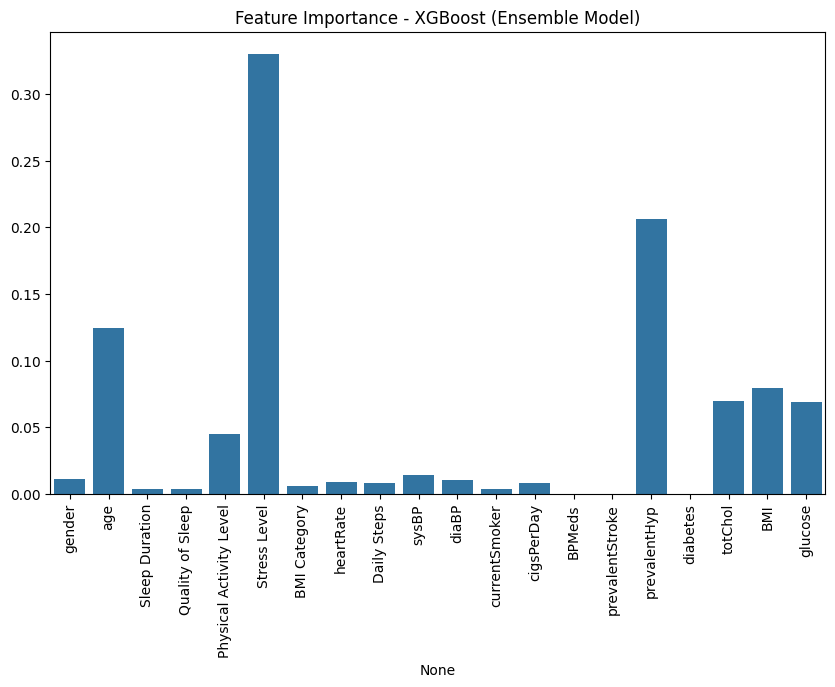

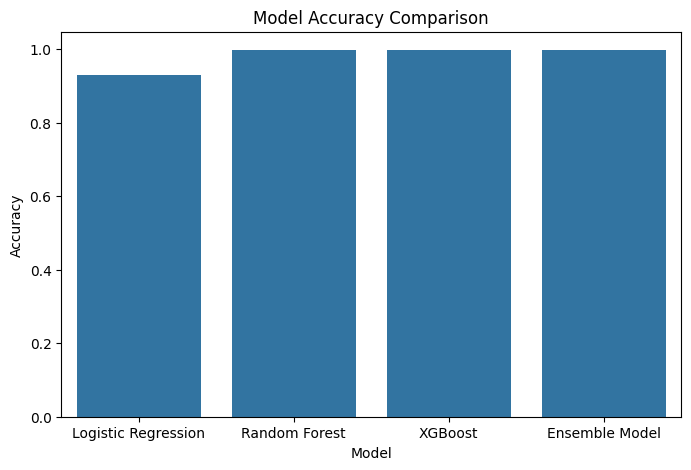

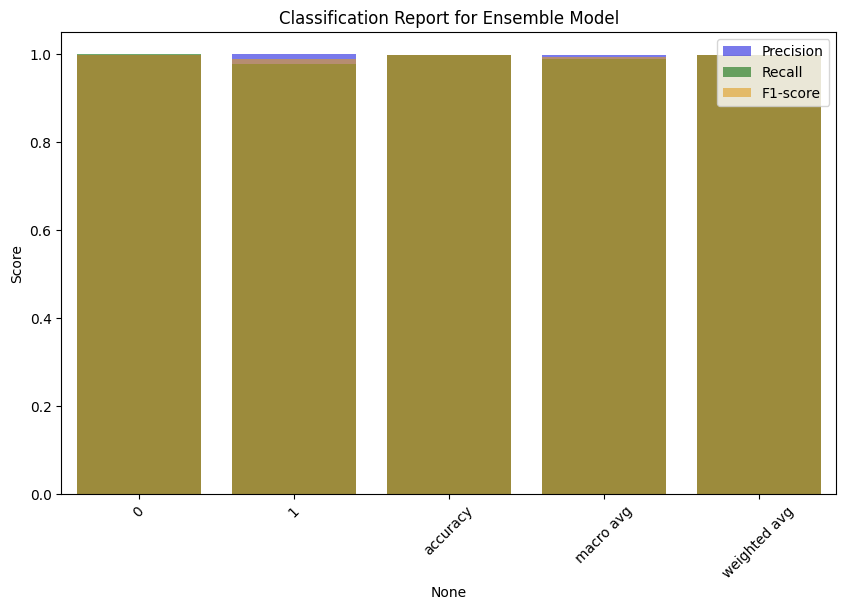

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

ensemble_model = VotingClassifier(
    estimators=[('rf', rf_model), ('xgb', xgb_model)],
    voting='hard'  # 'hard' for majority voting, or 'soft' for weighted voting based on probabilities
)

# Training the ensemble model
ensemble_model.fit(X_train, y_train)

ensemble_predictions = ensemble_model.predict(X_test)

# Calculating the accuracy
ensemble_accuracy = accuracy_score(y_test, ensemble_predictions)
ensemble_classification_report = classification_report(y_test, ensemble_predictions)

# Printing the accuracy and classification report
print("\nEnsemble Model (Random Forest + XGBoost) Accuracy:", ensemble_accuracy)
print("\nEnsemble Model Classification Report:\n", ensemble_classification_report)

# Confusion Matrix for the Ensemble Model
conf_matrix = confusion_matrix(y_test, ensemble_predictions)

# Plotting the Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['No CHD', 'CHD'], yticklabels=['No CHD', 'CHD'])
plt.title('Confusion Matrix - Ensemble Model (Random Forest + XGBoost)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance using Random Forest
rf_feature_importances = rf_model.feature_importances_
features = X.columns

# Plotting feature importance for Random Forest (part of the ensemble)
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=rf_feature_importances)
plt.title("Feature Importance - Random Forest (Ensemble Model)")
plt.xticks(rotation=90)
plt.show()

# Feature Importance using XGBoost (part of the ensemble)
xgb_feature_importances = xgb_model.feature_importances_

# Plotting feature importance for XGBoost (part of the ensemble)
plt.figure(figsize=(10, 6))
sns.barplot(x=features, y=xgb_feature_importances)
plt.title("Feature Importance - XGBoost (Ensemble Model)")
plt.xticks(rotation=90)
plt.show()

# Accuracy comparison of individual models vs ensemble model
accuracy_comparison = pd.DataFrame({
    'Model': ['Logistic Regression', 'Random Forest', 'XGBoost', 'Ensemble Model'],
    'Accuracy': [logreg_accuracy, rf_accuracy, xgb_accuracy, ensemble_accuracy]
})

# Plotting the accuracy comparison
plt.figure(figsize=(8, 5))
sns.barplot(x='Model', y='Accuracy', data=accuracy_comparison)
plt.title("Model Accuracy Comparison")
plt.show()

# Plotting the classification report (Precision, Recall, F1-score for each class)
report_dict = classification_report(y_test, ensemble_predictions, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()


plt.figure(figsize=(10, 6))
sns.barplot(x=report_df.index, y=report_df['precision'], color='blue', alpha=0.6, label='Precision')
sns.barplot(x=report_df.index, y=report_df['recall'], color='green', alpha=0.6, label='Recall')
sns.barplot(x=report_df.index, y=report_df['f1-score'], color='orange', alpha=0.6, label='F1-score')
plt.title("Classification Report for Ensemble Model")
plt.ylabel("Score")
plt.legend()
plt.xticks(rotation=45)
plt.show()


/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


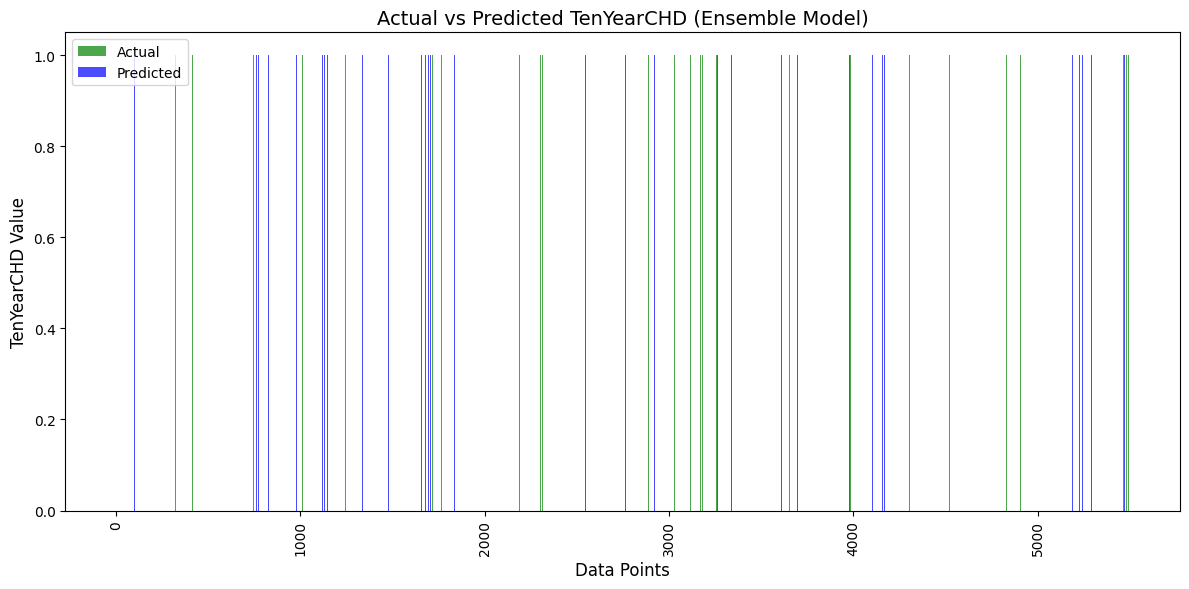

In [ ]:
plt.figure(figsize=(12, 6))

indices = np.arange(len(y_test))

# Set width of bars
bar_width = 0.35

plt.bar(indices - bar_width/2, y_test, bar_width, label='Actual', color='green', alpha=0.7)

plt.bar(indices + bar_width/2, ensemble_predictions, bar_width, label='Predicted', color='blue', alpha=0.7)

plt.title('Actual vs Predicted TenYearCHD (Ensemble Model)', fontsize=14)
plt.xlabel('Data Points', fontsize=12)
plt.ylabel('TenYearCHD Value', fontsize=12)

plt.legend()

plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


In [ ]:
def predict_new_data(model, user_input, label_encoders, imputer, scaler, features):
    user_input = user_input.reindex(columns=features, fill_value=0)

    for col, le in label_encoders.items():
        if col in user_input:
            user_input[col] = le.transform(user_input[col].astype(str))

    # Impute missing values
    user_input = imputer.transform(user_input)

    user_input = scaler.transform(user_input)

    # Predict using trained model
    return model.predict(user_input)

user_input_data = {
    'gender': ['Female'],
    'age': [45],
    'BMI Category': ['Overweight'],
    'Stress Level': [6],
    'heartRate': [78],
    'Daily Steps': [5000],
    'sysBP': [130],
    'diaBP': [85],
    'cigsPerDay': [5],
    'totChol': [230],
    'BMI': [27],
    'glucose': [95],
    'BPMeds': [0]
}

user_input = pd.DataFrame(user_input_data)

predicted_output = predict_new_data(ensemble_model, user_input, label_encoders, imputer, scaler, X.columns)

print(f"Predicted Output: [{predicted_output}]")


Predicted Output: [0]
